Goals:
- Train GAN to more epochs and resize Monet images to get reasonable output of CycleGAN <--
- ProgressiveGAN: only upsampling + downsampling <--
  - ask if problems?

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import kagglehub
import torchvision.transforms as T
from torchvision.utils import make_grid
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

In [2]:
to_tensor = T.ToTensor()

def load_image(path):
    return to_tensor(Image.open(path))


def show_images(imgs):
    # imgs is a tensor of shape: B x C x H x W
    grid = make_grid(imgs, nrow=4, padding=10, pad_value=1)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.gcf().set_figwidth(8)
    plt.show()

In [3]:
class Monet(Dataset):
    def __init__(self, img_size=256):
        self.data_path = kagglehub.dataset_download(
            "dimitreoliveira/monet-paintings-jpg-berkeley")
        self.img_names = os.listdir(self.data_path)
        self.img_names = list(filter(lambda s: os.path.isfile(os.path.join(self.data_path, s)), self.img_names))

        # resize images to lower resolution
        print("Image size:", img_size)
        if img_size == 256:
            self.resized_data_path = self.data_path
        else:
            self.resized_data_path = os.path.join(self.data_path, f"resized_{img_size}")
        
        print("Saving resized images...")
        for img_name in tqdm(self.img_names):
            resized_path = os.path.join(self.resized_data_path, img_name)
            if os.path.exists(resized_path):
                continue

            # resize to specified img size
            orig_img_path = os.path.join(self.data_path, img_name)
            with Image.open(orig_img_path) as img:
                resized_img = img.resize((img_size, img_size))
                # save
                os.makedirs(os.path.dirname(resized_path), exist_ok=True)
                resized_img.save(resized_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.resized_data_path, self.img_names[index]))


Data downloaded already


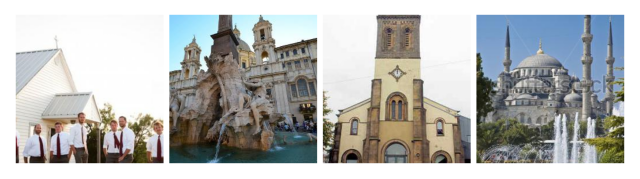

In [4]:
import requests
import zipfile

class LSUNChurchSubset(Dataset):
    def __init__(self, data_dir):

        self.data_path = os.path.abspath(os.path.join(data_dir, "lsun-subset"))
        os.makedirs(self.data_path, exist_ok=True)

        # download if not already downloaded
        if len(os.listdir(self.data_path)) == 2000:
            print("Data downloaded already")
        else:
            print("Downloading data")

            # get zip file from Adam's Duke Box
            zip_url = "https://duke.app.box.com/index.php?rm=box_download_shared_file&shared_name=0af4hdn4muor7rkickcrtp8ppk41n7dk&file_id=f_1713403290181"
            response = requests.get(zip_url, stream=True)
            response.raise_for_status()

            # write zip file to a temp file
            with open("temp.zip", "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)

            # extract files
            with zipfile.ZipFile("temp.zip", "r") as zip_ref:
                zip_ref.extractall(data_dir)

            # delete temp zip file
            os.remove("temp.zip")

        # get image names
        self.img_names = os.listdir(self.data_path)
    
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.data_path, self.img_names[index]))


loader = DataLoader(LSUNChurchSubset("lsun-church-subset"), batch_size=4, shuffle=True)
imgs = next(iter(loader))
show_images(imgs)

In [13]:
monet = Monet()
lsun = LSUNChurchSubset("lsun-church-subset")

batch_size = 2
monet_loader = DataLoader(monet, batch_size=batch_size, shuffle=True)
lsun_loader = DataLoader(lsun, batch_size=batch_size, shuffle=True)

Image size: 256
Saving resized images...


100%|██████████| 1193/1193 [00:00<00:00, 15683.01it/s]

Data downloaded already


Define models

In [6]:
from torch import nn
from torch.nn.utils.parametrizations import spectral_norm

class GeneratorResidualBlock(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_channels, n_channels, kernel_size=3),
            nn.InstanceNorm2d(n_channels),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_channels, n_channels, kernel_size=3),
            nn.InstanceNorm2d(n_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return x + self.layers(x)


class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        layers = []

        # initial convolution
        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        ]
        # downsample
        layers += [
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 256, kernel_size=3, stride=2),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        ]
        # residual blocks
        for _ in range(9):
            layers.append(GeneratorResidualBlock(256))
        # upsample
        layers += [
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        ]
        # final convolution
        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, kernel_size=7),
            nn.Sigmoid()
        ]

        # put all the layers together
        self.layers = nn.Sequential(*layers)


    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            # nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            # nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1)),
            # nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Output Layer: Conv -> Sigmoid
            nn.Conv2d(512, 1, kernel_size=3, stride=1),
            nn.Flatten(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


Generated Images:


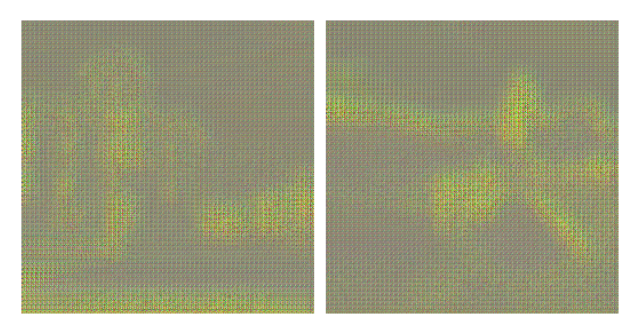

In [7]:
g = Generator()
d = Discriminator()

imgs = next(iter(lsun_loader))
fake_imgs = g(imgs)
print("Generated Images:")
show_images(fake_imgs[:8].detach().cpu())


In [80]:
import torch
import torch.optim as optim
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator_g = Generator().to(device)  # original img -> monet
generator_f = Generator().to(device)  # monet -> cifar

discriminator_x = Discriminator().to(device)  # For real
discriminator_y = Discriminator().to(device)  # For Monet

# Loss functions
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

# Labels
real_label = 1.0
fake_label = 0.0


In [81]:
# Hyperparameters
num_epochs = 10
lr = 0.0002
lambda_cycle = 10
lambda_identity = 5

# Optimizers
optimizer_g = optim.Adam(list(generator_g.parameters()) + list(generator_f.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_dx = optim.Adam(discriminator_x.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_dy = optim.Adam(discriminator_y.parameters(), lr=lr, betas=(0.5, 0.999))

In [82]:
# Define buffer to hold a history of fake images
# The discriminator will be trained on a set of fake images, where each has probability 0.5
# of coming from the current minibatch, and probability 0.5 coming from recent fake images.
# Each image has probability 0.5 of being swapped into the image history to update it.
# This helps stabilize the discriminator, so it's less sensitive to the current minibatch

class FakeImageBuffer():
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.img_history = []
    
    def swap(self, mini_batch):
        swapped_mini_batch = []
        for img in mini_batch.data:
            img = torch.unsqueeze(img, 0)
            if len(self.img_history) < self.max_size:
                self.img_history.append(img)
                swapped_mini_batch.append(img)
            else:
                if torch.rand(1) > 0.5:
                    # don't swap
                    swapped_mini_batch.append(img)
                else:
                    # pick random prev img to swap with
                    i = torch.randint(0, self.max_size, (1,))
                    swapped_mini_batch.append(self.img_history[i].clone())
                    self.img_history[i] = img
        return torch.cat(swapped_mini_batch)

fake_x_history = FakeImageBuffer()  # photos
fake_y_history = FakeImageBuffer()  # monet

In [89]:
# utility functions to save progress to an image file every once in a while
# so we don't have to stop the training to see what's going on

def imshow_on_axis(img, ax):
    np_img = img.detach().permute(1,2,0).cpu().numpy()
    ax.axis("off")
    ax.imshow(np_img)

def save_progress_file(real_x, real_y, fake_x, fake_y, cycle_x, cycle_y):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    axes[0][0].set_title("photo -->")
    imshow_on_axis(real_x[0], axes[0][0])
    axes[0][1].set_title("monet")
    imshow_on_axis(fake_y[0], axes[0][1])
    axes[0][2].set_title("--> photo")
    imshow_on_axis(cycle_x[0], axes[0][2])
    axes[1][0].set_title("monet -->")
    imshow_on_axis(real_y[0], axes[1][0])
    axes[1][1].set_title("photo")
    imshow_on_axis(fake_x[0], axes[1][1])
    axes[1][2].set_title("--> monet")
    imshow_on_axis(cycle_y[0], axes[1][2])
    fig.tight_layout()
    fig.savefig("progress.png")
    plt.close()  # don't print temp figures to the notebok

In [91]:
# Training loop
for epoch in range(num_epochs):
    for b, (real_x, real_y) in enumerate(zip(lsun_loader, monet_loader)):
        # Prepare data
        real_x = real_x.to(device)  # photos
        real_y = real_y.to(device)  # Monet images

        # -------------------------------------------
        #  Train Generators (G and F)
        # -------------------------------------------
        optimizer_g.zero_grad()

        # Adversarial loss
        fake_y = generator_g(real_x)  # X -> Y
        pred_fake_y = discriminator_y(fake_y)
        loss_g_adv = adversarial_loss(pred_fake_y, torch.ones_like(pred_fake_y).to(device))

        fake_x = generator_f(real_y)  # Y -> X
        pred_fake_x = discriminator_x(fake_x)
        loss_f_adv = adversarial_loss(pred_fake_x, torch.ones_like(pred_fake_x).to(device))

        # Cycle consistency loss
        cycle_x = generator_f(fake_y)  # X -> Y -> X
        loss_cycle_x = cycle_loss(cycle_x, real_x)

        cycle_y = generator_g(fake_x)  # Y -> X -> Y
        loss_cycle_y = cycle_loss(cycle_y, real_y)

        # Identity loss
        identity_x = generator_f(real_x)  # X -> X
        loss_id_x = identity_loss(identity_x, real_x)

        identity_y = generator_g(real_y)  # Y -> Y
        loss_id_y = identity_loss(identity_y, real_y)

        # Total generator loss
        loss_g = loss_g_adv + loss_f_adv + lambda_cycle * (loss_cycle_x + loss_cycle_y) + lambda_identity * (loss_id_x + loss_id_y)
        loss_g.backward()
        optimizer_g.step()

        # -----------------------------------------------
        # save image to show progress every once in a while
        # do this before we swap out fake images with the history during discriminator update
        if b % 25 == 0:
            save_progress_file(real_x, real_y, fake_x, fake_y, cycle_x, cycle_y)
        # -------------------------------------------------

        # -------------------------------------------
        #  Train Discriminators (X and Y)
        # -------------------------------------------
        # Discriminator X
        optimizer_dx.zero_grad()

        pred_real_x = discriminator_x(real_x)
        loss_dx_real = adversarial_loss(pred_real_x, torch.ones_like(pred_real_x).to(device))

        fake_x = fake_x_history.swap(fake_x)
        pred_fake_x = discriminator_x(fake_x.detach())
        loss_dx_fake = adversarial_loss(pred_fake_x, torch.zeros_like(pred_fake_x).to(device))

        loss_dx = (loss_dx_real + loss_dx_fake) * 0.5
        loss_dx.backward()
        optimizer_dx.step()

        # Discriminator Y
        optimizer_dy.zero_grad()

        fake_y = fake_y_history.swap(fake_y)
        pred_real_y = discriminator_y(real_y)
        loss_dy_real = adversarial_loss(pred_real_y, torch.ones_like(pred_real_y).to(device))

        pred_fake_y = discriminator_y(fake_y.detach())
        loss_dy_fake = adversarial_loss(pred_fake_y, torch.zeros_like(pred_fake_y).to(device))

        loss_dy = (loss_dy_real + loss_dy_fake) * 0.5
        loss_dy.backward()
        optimizer_dy.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}] Batch [{b + 1}/{len(monet_loader)}] | Loss G: {loss_g.item():.4f} | Loss DX: {loss_dx.item():.4f} | Loss DY: {loss_dy.item():.4f}")

torch.save(generator_g.state_dict(), "lsun_generator_g.pth")
torch.save(generator_f.state_dict(), "lsun_generator_f.pth")
torch.save(discriminator_x.state_dict(), "lsun_discriminator_x.pth")
torch.save(discriminator_y.state_dict(), "lsun_discriminator_y.pth")

Epoch [1/10] Batch [1/597] | Loss G: 2.8939 | Loss DX: 0.1375 | Loss DY: 0.0333
Epoch [1/10] Batch [2/597] | Loss G: 3.3094 | Loss DX: 0.2402 | Loss DY: 0.1292
Epoch [1/10] Batch [3/597] | Loss G: 2.7580 | Loss DX: 0.4485 | Loss DY: 0.4506
Epoch [1/10] Batch [4/597] | Loss G: 2.8919 | Loss DX: 0.3257 | Loss DY: 0.2781
Epoch [1/10] Batch [5/597] | Loss G: 3.0128 | Loss DX: 0.4104 | Loss DY: 0.4632
Epoch [1/10] Batch [6/597] | Loss G: 2.6850 | Loss DX: 0.3391 | Loss DY: 0.3162
Epoch [1/10] Batch [7/597] | Loss G: 3.0608 | Loss DX: 0.2245 | Loss DY: 0.3553
Epoch [1/10] Batch [8/597] | Loss G: 2.4548 | Loss DX: 0.2037 | Loss DY: 0.2559
Epoch [1/10] Batch [9/597] | Loss G: 2.5147 | Loss DX: 0.1995 | Loss DY: 0.2389
Epoch [1/10] Batch [10/597] | Loss G: 2.5433 | Loss DX: 0.2730 | Loss DY: 0.3236
Epoch [1/10] Batch [11/597] | Loss G: 2.1790 | Loss DX: 0.2249 | Loss DY: 0.3216
Epoch [1/10] Batch [12/597] | Loss G: 1.8838 | Loss DX: 0.3130 | Loss DY: 0.1896
Epoch [1/10] Batch [13/597] | Loss G:

KeyboardInterrupt: 

In [186]:
torch.save(generator_g.state_dict(), "lsun_generator_g.pth")
torch.save(generator_f.state_dict(), "lsun_generator_f.pth")
torch.save(discriminator_x.state_dict(), "lsun_discriminator_x.pth")
torch.save(discriminator_y.state_dict(), "lsun_discriminator_y.pth")

In [90]:
generator_g.load_state_dict(torch.load("lsun_generator_g.pth", weights_only=True))
generator_f.load_state_dict(torch.load("lsun_generator_f.pth", weights_only=True))
discriminator_x.load_state_dict(torch.load("lsun_discriminator_x.pth", weights_only=True))
discriminator_y.load_state_dict(torch.load("lsun_discriminator_y.pth", weights_only=True))

<All keys matched successfully>

LSUN Images


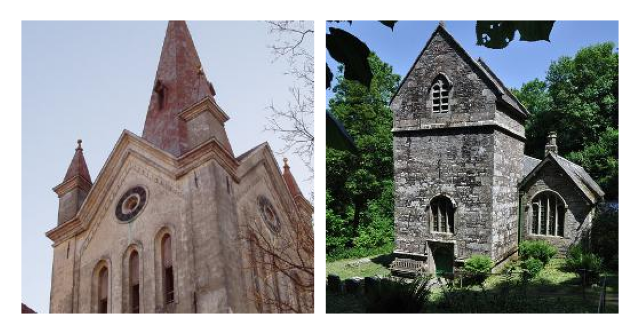

Generated Monet-style Images


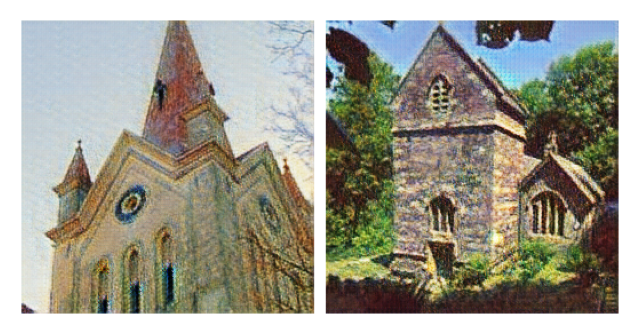

Reconstructed LSUN Images


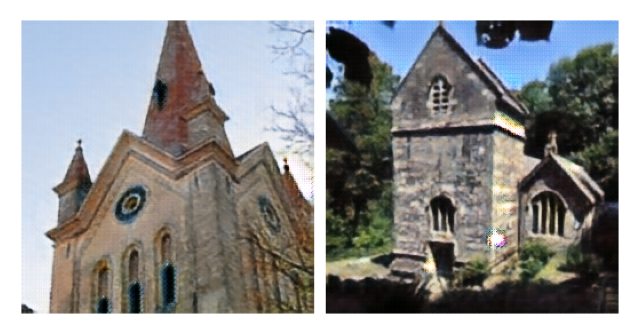

In [93]:
# now let's test our cyclegan after training to see if it actually works:

real_x  = next(iter(lsun_loader))
real_x = real_x.cuda()

fake_y = generator_g(real_x).detach()
reconstructed_x = generator_f(fake_y).detach()

fake_y = fake_y.cpu()
reconstructed_x = reconstructed_x.cpu()

n_to_show = 2  # less than or equal to batch size
print("LSUN Images")
show_images(real_x[:n_to_show].cpu())
print("Generated Monet-style Images")
show_images(fake_y[:n_to_show])
print("Reconstructed LSUN Images")
show_images(reconstructed_x[:n_to_show])


### Calculate Inception Score and FID

We use a library documented here: https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/

Inception Score

In [ ]:
from ignite.metrics import InceptionScore
from ignite.engine import Engine
from torchvision.transforms import ToPILImage, ToTensor

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(ToTensor()(resized_img))
    return torch.stack(arr)

def evaluation_step(engine, batch):
    with torch.no_grad():
        real_x = next(iter(lsun_loader)).to(device)
        fake_paintings = generator_g(real_x)
        fake_paintings = interpolate(fake_paintings)
        return fake_paintings

evaluator = Engine(evaluation_step)

is_metric = InceptionScore()
is_metric.attach(evaluator, "is")

state = evaluator.run(monet_loader)
state.metrics["is"]


FID

In [ ]:
from ignite.metrics import FID
from ignite.engine import Engine
from torchvision.transforms import ToPILImage, ToTensor

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(ToTensor()(resized_img))
    return torch.stack(arr)

def evaluation_step(engine, batch):
    with torch.no_grad():
        real_x = next(iter(lsun_loader)).to(device)
        real_x = real_x[:batch.shape[0]]
        fake_paintings = generator_g(real_x)
        fake_paintings = interpolate(fake_paintings)
        real_paintings = interpolate(batch)
        return fake_paintings, real_paintings

evaluator = Engine(evaluation_step)

fid_metric = FID()
fid_metric.attach(evaluator, "fid")

state = evaluator.run(monet_loader)
state.metrics["fid"]
